<a href="https://www.kaggle.com/code/andriybabiy/02-image-classification-intel-image-classification?scriptVersionId=200861724" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 02_Image_Classification
Using the Intel Image Classification dataset, my goal is to develop and train a deep learining model that will attempt to correctly classify the images.

In [1]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tempfile import TemporaryDirectory

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

torch.cuda.empty_cache()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

plt.ion() # interactive mode

import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [2]:
resize_size = (224, 224)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(resize_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(resize_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(resize_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Download and prepare the data for processing

In [3]:
# Kaggle
path_to_dir = '/kaggle/input/intel-image-classification'

pred = '/kaggle/input/intel-image-classification/seg_pred'
test = '/kaggle/input/intel-image-classification/seg_test/seg_test'
train = '/kaggle/input/intel-image-classification/seg_train/seg_train'

path_to_model = '/kaggle/working/'
model_filename = 'baseline_model.pth'
path_to_model_file = os.path.join(path_to_model, model_filename)

path_to_model_file

'/kaggle/working/baseline_model.pth'

In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(path_to_dir, 'seg_' + x, 'seg_' + x), data_transforms[x]) for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 14034, 'test': 3000}
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


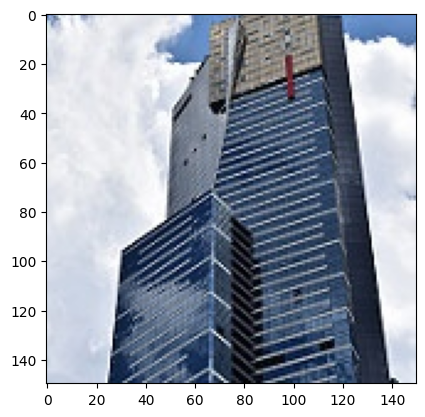

In [5]:
im = Image.open('/kaggle/input/intel-image-classification/seg_test/seg_test/buildings/20057.jpg')
plt.imshow(im)
plt.show() # image will not be displayed without this

### Display image examples

In [6]:
def imshow(images, labels, class_names):
    
    images = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    plt.title(", ".join([class_names[l] for l in labels]))
    plt.show()

In [7]:
dataiter = iter(dataloaders['train'])
images, labels = next(dataiter)

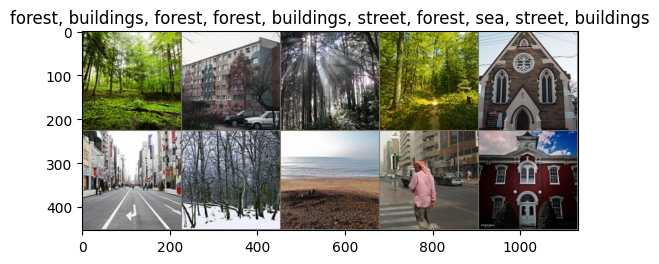

In [8]:
imshow(make_grid(images[:10], nrow=5), labels[:10], class_names)

## Develop the architecture for a convolutional neural network (CNN) for image classification

### Baseline Model

In [9]:
class BaselineModel(nn.Module):
    def __init__(self, ):
        super(BaselineModel, self).__init__()
        self.num_channels = 32
        
        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)
        
        self.num_features = self._get_num_features()
        
#         self.fc1 = nn.Linear(8*8*self.num_channels*4, self.num_channels*4)
        self.fc1 = nn.Linear(self.num_features, self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)
        
    def _get_num_features(self):
        dummy_input = torch.zeros(1, 3, 224, 224)
        output = self._forward_conv_layers(dummy_input)
        num_features = output.view(1, -1).size(1)
        return num_features
    
    def _forward_conv_layers(self, x):
#         x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, 2))
#         x = self.conv2(x)
        x = F.relu(F.max_pool2d(x, 2))
#         x = self.conv3(x)
        x = F.relu(F.max_pool2d(x, 2))
        return x
        
    def forward(self, s):
        s = self._forward_conv_layers(s)
        
        s = s.view(s.size(0), -1)
        
        s = F.relu(self.fc1(s))
        s = self.fc2(s)
        
        return F.log_softmax(s, dim=1)

In [10]:
cuda = torch.cuda.is_available()

torch.manual_seed(42)
if cuda:
    torch.cuda.manual_seed(42)

device = 'cuda' if cuda else None

In [11]:
model = BaselineModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss().to(device)

num_epochs = 15

In [12]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

num_ftrs = model_ft.fc.in_features  # This gets the size of the final feature map
model_ft.fc = nn.Linear(num_ftrs, len(class_names))  # Adjust for your dataset

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-05)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


In [13]:
model

BaselineModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [14]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train the model on the training dataset

In [15]:
def train_model(model, criterion, optimizer, num_epochs=25):# scheduler, num_epochs=25):
    since = time.time()
    
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc.item())
                else:
                    test_losses.append(epoch_loss)
                    test_accs.append(epoch_acc.item())
                    
            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
        
    return model, train_losses, train_accs, test_losses, test_accs

In [16]:
model, train_losses, train_accs, test_losses, test_accs = train_model(model, criterion, optimizer, num_epochs=15)

Epoch 1/15
----------
train Loss: 1.6252 Acc: 0.3633
test Loss: 1.5159 Acc: 0.4377

Epoch 2/15
----------
train Loss: 1.4542 Acc: 0.4644
test Loss: 1.4330 Acc: 0.4563

Epoch 3/15
----------
train Loss: 1.3897 Acc: 0.4890
test Loss: 1.3955 Acc: 0.4697

Epoch 4/15
----------
train Loss: 1.3526 Acc: 0.5010
test Loss: 1.3687 Acc: 0.4857

Epoch 5/15
----------
train Loss: 1.3283 Acc: 0.5127
test Loss: 1.3553 Acc: 0.4880

Epoch 6/15
----------
train Loss: 1.3079 Acc: 0.5186
test Loss: 1.3361 Acc: 0.5063

Epoch 7/15
----------
train Loss: 1.2910 Acc: 0.5247
test Loss: 1.3238 Acc: 0.5107

Epoch 8/15
----------
train Loss: 1.2758 Acc: 0.5310
test Loss: 1.3153 Acc: 0.5027

Epoch 9/15
----------
train Loss: 1.2637 Acc: 0.5339
test Loss: 1.3004 Acc: 0.5160

Epoch 10/15
----------
train Loss: 1.2511 Acc: 0.5380
test Loss: 1.2934 Acc: 0.5150

Epoch 11/15
----------
train Loss: 1.2416 Acc: 0.5403
test Loss: 1.2831 Acc: 0.5173

Epoch 12/15
----------
train Loss: 1.2324 Acc: 0.5445
test Loss: 1.2764 Ac

In [19]:
torch.save(model.state_dict(), path_to_model_file)
print(f"Model saved to {path_to_model_file}")

Model saved to /kaggle/working/baseline_model.pth


In [20]:
torch.cuda.empty_cache()

In [24]:
model_ft, ft_train_losses, ft_train_accs, ft_test_losses, ft_test_accs  = train_model(model_ft, criterion, optimizer_ft, num_epochs=15)

Epoch 1/15
----------
train Loss: 0.1669 Acc: 0.9458
test Loss: 0.1750 Acc: 0.9380

Epoch 2/15
----------
train Loss: 0.1408 Acc: 0.9549
test Loss: 0.1736 Acc: 0.9393

Epoch 3/15
----------
train Loss: 0.1129 Acc: 0.9642
test Loss: 0.1689 Acc: 0.9397

Epoch 4/15
----------
train Loss: 0.0962 Acc: 0.9715
test Loss: 0.1651 Acc: 0.9427

Epoch 5/15
----------
train Loss: 0.0787 Acc: 0.9768
test Loss: 0.1734 Acc: 0.9423

Epoch 6/15
----------
train Loss: 0.0584 Acc: 0.9844
test Loss: 0.1720 Acc: 0.9427

Epoch 7/15
----------
train Loss: 0.0496 Acc: 0.9880
test Loss: 0.1805 Acc: 0.9397

Epoch 8/15
----------
train Loss: 0.0398 Acc: 0.9904
test Loss: 0.1806 Acc: 0.9437

Epoch 9/15
----------
train Loss: 0.0302 Acc: 0.9939
test Loss: 0.1942 Acc: 0.9403

Epoch 10/15
----------
train Loss: 0.0282 Acc: 0.9942
test Loss: 0.2003 Acc: 0.9403

Epoch 11/15
----------
train Loss: 0.0210 Acc: 0.9959
test Loss: 0.2065 Acc: 0.9387

Epoch 12/15
----------
train Loss: 0.0193 Acc: 0.9961
test Loss: 0.1983 Ac

In [25]:
pretrained_model_filename = 'pretrained_model.pth'
path_to_pretrained_model_file = os.path.join(path_to_model, pretrained_model_filename)

torch.save(model_ft.state_dict(), path_to_pretrained_model_file)
print(f"Model saved to {path_to_pretrained_model_file}")

Model saved to /kaggle/working/pretrained_model.pth


## Analyze the effectiveness of the model using the valid and test datasets

In [26]:
def visualize_predictions(model, dataloader, class_names, num_images=5):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

                images_so_far += 1
                ax = plt.subplot(num_images//2 + 1, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')

                # Денормалізація зображення для відображення
                inv_normalize = transforms.Normalize(
                    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std=[1/0.229, 1/0.224, 1/0.225]
                )
                inp = inv_normalize(inputs.cpu()[j]).numpy().transpose((1, 2, 0))
                inp = np.clip(inp, 0, 1)

                plt.imshow(inp)

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()

In [27]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

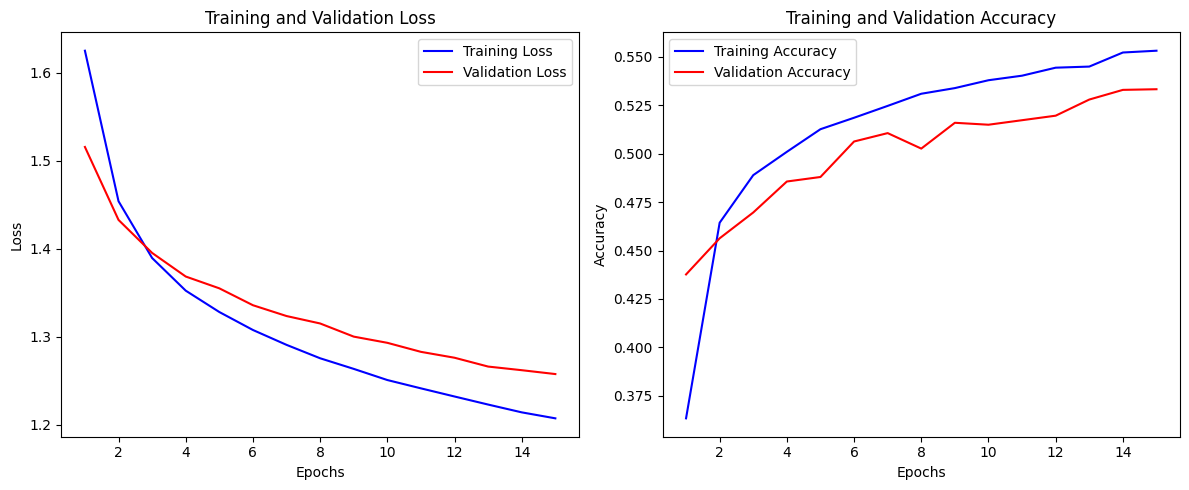

In [28]:
plot_training_metrics(train_losses, train_accs, test_losses, test_accs)

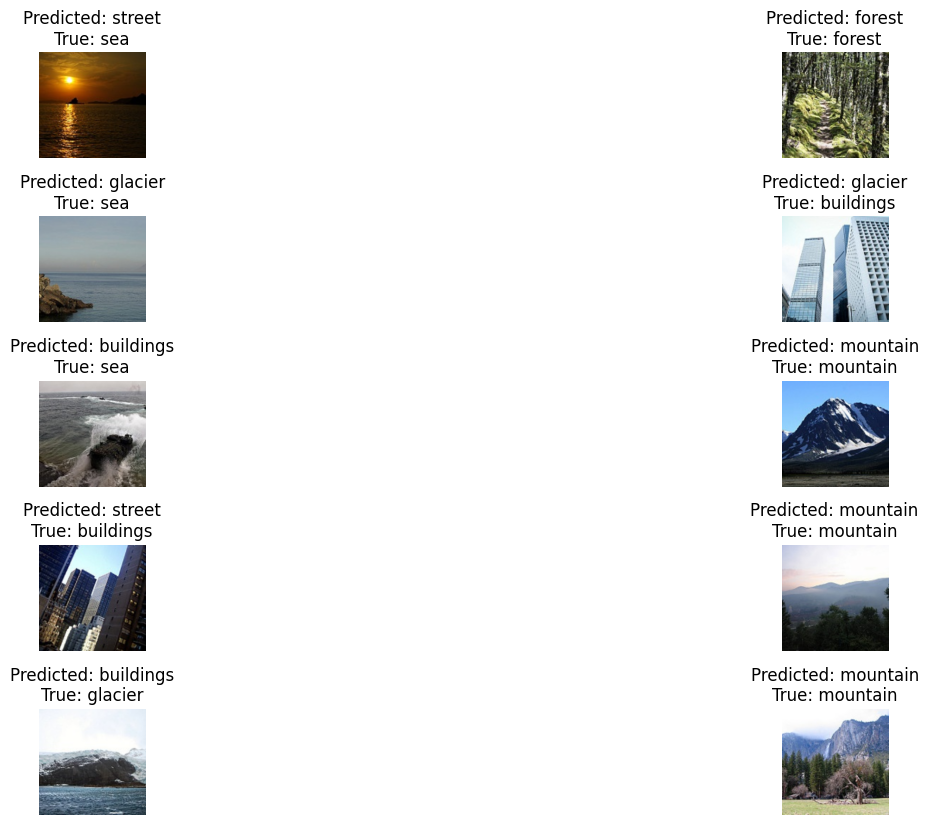

In [29]:
visualize_predictions(model, dataloaders['test'], class_names, 10)

In [30]:
def evaluate_model(model):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

# Get predictions and true labels for test data
y_true, y_pred = evaluate_model(model)

# Calculate F1-score and print classification report
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1-score (weighted): {f1:.4f}')

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bb80aadc040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bb80aadc040>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bb80aadc040>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/opt/conda/lib/python3.10/site-packages/t

F1-score (weighted): 0.5220
              precision    recall  f1-score   support

   buildings       0.38      0.48      0.43       437
      forest       0.78      0.64      0.70       474
     glacier       0.53      0.64      0.58       553
    mountain       0.53      0.66      0.59       525
         sea       0.40      0.18      0.25       510
      street       0.57      0.58      0.58       501

    accuracy                           0.53      3000
   macro avg       0.53      0.53      0.52      3000
weighted avg       0.53      0.53      0.52      3000



## Analysis of a pretrained model

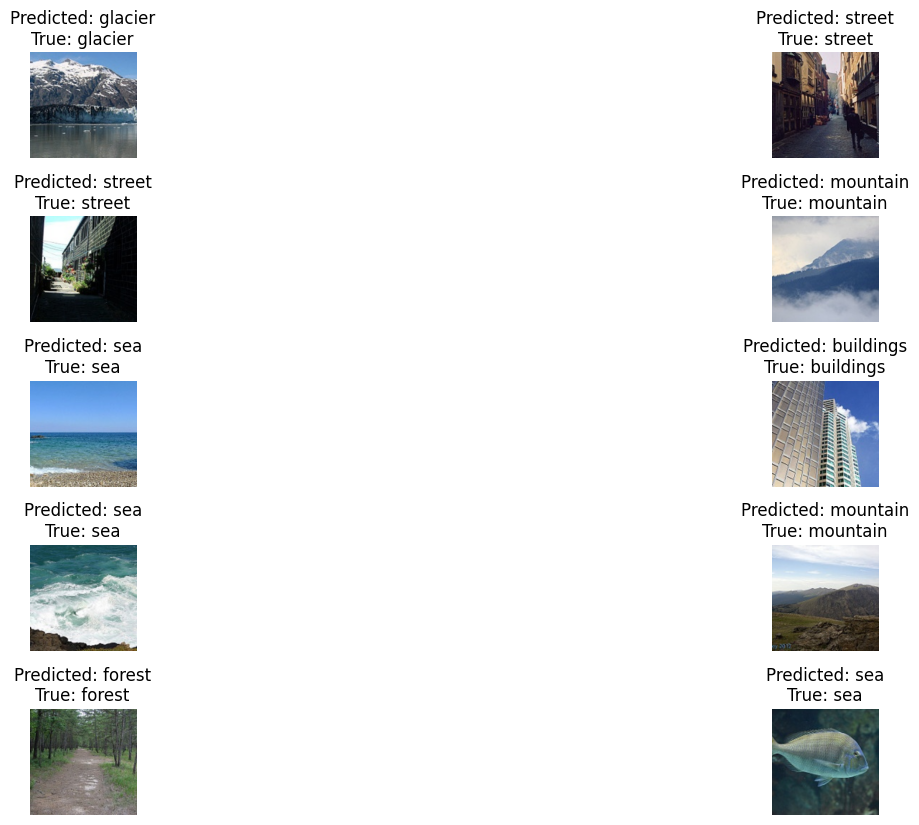

In [31]:
visualize_predictions(model_ft, dataloaders['test'], class_names, 10)

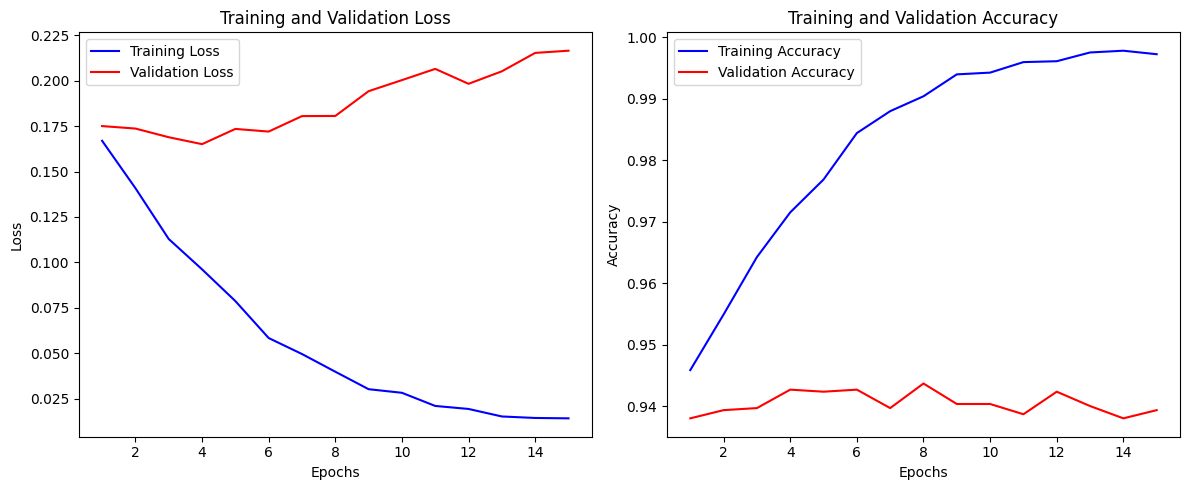

In [32]:
plot_training_metrics(ft_train_losses, ft_train_accs, ft_test_losses, ft_test_accs)

In [33]:
def evaluate_model(model):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

# Get predictions and true labels for test data
y_true, y_pred = evaluate_model(model_ft)

# Calculate F1-score and print classification report
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1-score (weighted): {f1:.4f}')

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

F1-score (weighted): 0.9435
              precision    recall  f1-score   support

   buildings       0.93      0.93      0.93       437
      forest       0.99      1.00      0.99       474
     glacier       0.93      0.89      0.91       553
    mountain       0.90      0.91      0.91       525
         sea       0.96      0.99      0.98       510
      street       0.95      0.94      0.95       501

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



## Analyze the results and proposal of further potential improvements of the model

After the initial run of the custom model, even during the state of training the model it was clearly evident that the model was overfitting as the model was improving its performance on the train dataset while slowly getting worse on the test dataset. However upon checking the results using a classification_report of the results of evaluating the model using the test dataset it showed an accuracy and F1 score of 83%.

Followining this I decided to also test a transfer model using the resnet18 model. For this I tried to train the model on a similar 15epochs to the custom model and found that the model was not training properly. The resulting model performance was unsatisfactory as at the hyperparameter levels of an Adam optimiser with a learning rate of 1e-3, and I increased the number of epochs to 100 at the same learning rate. These changes did not seem to have much of an impact as the Learning Loss and Accuracy were both oscillating around 1.9 and 17-19% respectively. Following this I attempted to change the learning rate to be 0.01 in order to have the model be more flexible in traversing the data while training in order to better learn and exit potential local minimums, however, once again the results were similarly oscilating in the same ranges.

In the ultimate version I decided to train both models in 15 epochs due to computational restrictions with the GPU. For the optimizer both models used the Adam optimizer with a learning rate of around 1e-5 and a CrossEntropyLoss criteria.

While the custom model had an ultimate training accuracy of around 55%, the transfer learning model had an ultimate accuracy of around 94%, this showed that there is clearly a reason to use the pre-existing models such as resnet in order to train new image classification models in order to have better overall performance.

As we can see by both of the "Training and Validation Loss" and the "Training and Validation Accuracy" diagrams, the custom model had a better training and accuracy direction while the Transfer model started at a level of high performance and was affected by overfitting throughout the training. The further improvements that could be applied to this is to use more epochs in the training of the custom model in order to moitor if the trajectory will continue to follow the exisitng trend. As for the Transfer learning model there is room to try different learning rates that are less that 1e-5 in order to have the weights have more room to adjust and change.

